In [16]:
%matplotlib inline

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json

from typing import Dict, List

from network import Network

In [18]:
FIG_NUM = 0

In [19]:
def load_configurations(file_name = "config.json"):
    with open(file_name, encoding="utf-8", mode="r") as file:
        raw_data = file.read()
    return json.loads(raw_data)['config']

In [20]:
def generate_demand_matrix(graph: nx.Graph) -> np.array:
    nodes_num = len(graph.nodes)
    demand_matrix = np.zeros((nodes_num, nodes_num))
    for edge in graph.edges:
        demand_matrix[edge[0], edge[1]] = np.random.randint(1, 10)
        demand_matrix[edge[1], edge[0]] = demand_matrix[edge[0], edge[1]]
    return demand_matrix

In [21]:
def create_demand_matrix_for_configuration(config: Dict):
    G = None
    vertex_num = config['vertex_num']
    if config['graph'] == "erdos-renyi":
        G = nx.erdos_renyi_graph(vertex_num, 1/vertex_num * config['constant'])
    elif config['graph'] == "barabasi-albert":
        G = nx.barabasi_albert_graph(vertex_num, config['m'])
    elif config['graph'] == "manual":
        return config['demand']
    else:
        raise NameError("Unknown graph type", config['graph'])

    return generate_demand_matrix(G).tolist()

In [22]:
def render_egotrees(network: Network):
    global FIG_NUM
    for tree in network.egotrees:
        FIG_NUM += 1
        G = nx.Graph()
        queue = [tree]
        while queue:
            ctree = queue.pop(0)
            root = ctree.root.label
            G.add_node(root, label=root)
            for leave in ctree.leaves:
                queue.append(leave)
                G.add_node(leave.root.label)
                G.add_edge(root, leave.root.label, w=leave.weight())
        colors = []
        for node in G:
            if node == tree.root.label:
                # sarga a gyoker szine, mivel nincs tree layout
                colors.append('yellow')
            else:
                colors.append('red')
        pos = nx.kamada_kawai_layout(G)
        plt.figure(FIG_NUM)
        nx.draw(G, pos, node_color=colors)
        labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos, labels)
        weights = nx.get_edge_attributes(G, 'w')
        nx.draw_networkx_edge_labels(G, pos, weights)

In [23]:
def render_original_network(network: Network):
    global FIG_NUM
    G = nx.Graph()
    for i in range(len(network.demand_matrix)):
        G.add_node(i, label=str(i))

    for i in range(len(network.demand_matrix) - 1):
        for j in range(i + 1, len(network.demand_matrix)):
            if network.demand_matrix[i][j] > 0:
                G.add_edge(i, j, w=network.demand_matrix[i][j])

    pos = nx.circular_layout(G)
    plt.figure(FIG_NUM)
    FIG_NUM += 1
    nx.draw(G, pos)
    labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels)
    weights = nx.get_edge_attributes(G, 'w')
    nx.draw_networkx_edge_labels(G, pos, weights)

In [24]:
def render_new_network(network: Network):
    Gn = nx.Graph()
    for i in range(len(network.demand_matrix)):
        Gn.add_node(i, label=str(i))

    for edge in network.routing_scheme:
        Gn.add_edge(edge.v1.index, edge.v2.index, w=edge.probability)

    pos = nx.circular_layout(Gn)
    plt.figure(300)

    colors = []
    for node in Gn:
        if node in network.H_i:
            colors.append("red")
        else:
            colors.append("green")

    nx.draw(Gn, pos, with_labels=False, node_color=colors)
    labels = nx.get_node_attributes(Gn, 'label')
    nx.draw_networkx_labels(Gn, pos, labels)
    weights = nx.get_edge_attributes(Gn, 'w')
    nx.draw_networkx_edge_labels(Gn, pos, weights)

In [25]:
def render_everyting(network: Network):
    render_original_network(network)
    render_egotrees(network)
    render_new_network(network)

In [26]:
configurations = load_configurations()

In [41]:
for item in configurations:
    print(json.dumps(item, indent=2))

{
  "graph": "erdos-renyi",
  "vertex_num": 11,
  "dan": null,
  "constant": 3
}
{
  "graph": "barabasi-albert",
  "vertex_num": 11,
  "dan": null,
  "m": 4
}
{
  "graph": "manual",
  "vertex_num": null,
  "dan": 2,
  "demand": [
    [
      0,
      3,
      4,
      1,
      1,
      1,
      1
    ],
    [
      3,
      0,
      2,
      0,
      1,
      0,
      4
    ],
    [
      4,
      2,
      0,
      2,
      0,
      0,
      4
    ],
    [
      1,
      0,
      2,
      0,
      3,
      0,
      0
    ],
    [
      1,
      1,
      0,
      3,
      0,
      0,
      0
    ],
    [
      1,
      0,
      0,
      0,
      0,
      0,
      3
    ],
    [
      1,
      4,
      4,
      0,
      0,
      3,
      0
    ]
  ]
}


In [35]:
active_config = configurations[2]

demand_matrix = create_demand_matrix_for_configuration(active_config)

network = Network(demand_matrix)

network.create_dan(active_config['dan'])

[(Vertex: T0, 6), (Vertex: T1, 4), (Vertex: T2, 4), (Vertex: T6, 4)]
[(Vertex: T5, 2), (Vertex: T3, 3), (Vertex: T4, 3)]
Vertex: T0 Vertex: T1 Helper: Vertex: T5
Vertex: T0 Vertex: T2 Helper: Vertex: T3
Vertex: T0 Vertex: T6 Helper: Vertex: T4
Vertex: T1 Vertex: T2 Helper: Vertex: T4
Vertex: T1 Vertex: T6 Helper: Vertex: T3
Vertex: T2 Vertex: T6 Helper: Vertex: T5
[0, 3, 4, 1, 1, 1, 1]
[3, 0, 2, 0, 1, 0, 4]
[4, 2, 0, 2, 0, 0, 4]
[1, 0, 2, 0, 3, 0, 0]
[1, 1, 0, 3, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 3]
[1, 4, 4, 0, 0, 3, 0]
T0 L: [T2 L: [T4 L: [], T6 L: []], T1 L: [T3 L: [], T5 L: []]]
T1 L: [T6 L: [T4 L: []], T0 L: [T2 L: []]]
T2 L: [T0 L: [T1 L: []], T6 L: [T3 L: []]]
T6 L: [T1 L: [T5 L: []], T2 L: [T0 L: []]]
---- EGO TREES BEFORE ----
T0 L: [T2 L: [T4 L: [], T6 L: []], T1 L: [T3 L: [], T5 L: []]]
T1 L: [T6 L: [T4 L: []], T0 L: [T2 L: []]]
T2 L: [T0 L: [T1 L: []], T6 L: [T3 L: []]]
T6 L: [T1 L: [T5 L: []], T2 L: [T0 L: []]]
--------------------------
Tree before T0 L: [T2 L: [T4 L: [], T6 L:

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


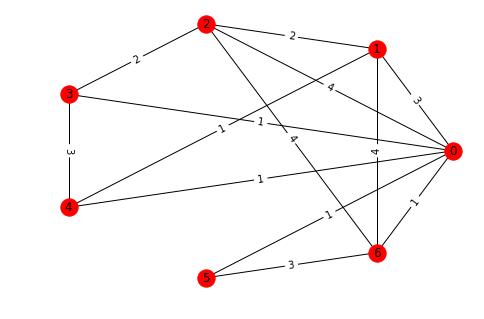

In [36]:
render_original_network(network)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


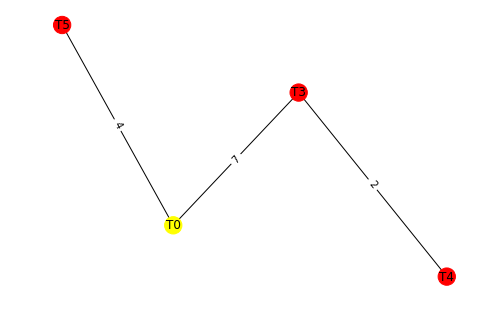

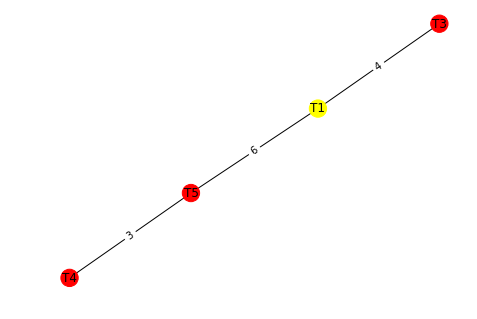

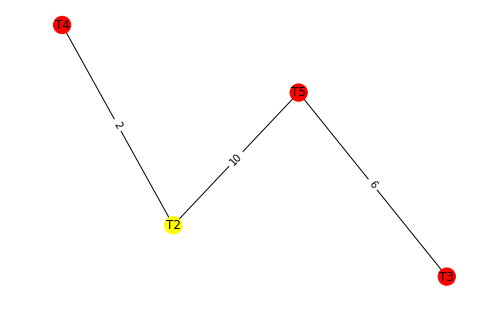

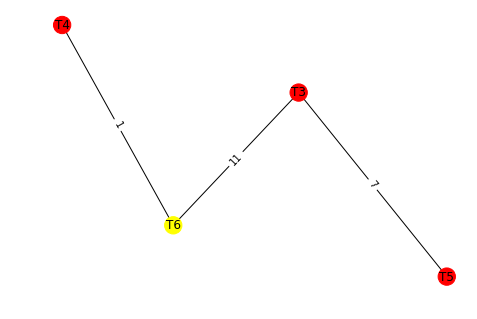

In [37]:
render_egotrees(network)

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


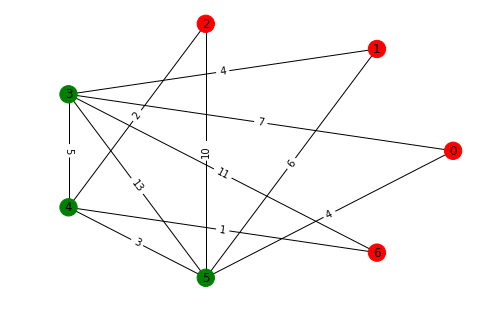

In [38]:
render_new_network(network)